# Compartimentalization 

## 1-Theory
In this section, previsouly called quantities "$X_i^p$" and "$X_j^n$" are  the number of positive particle of type $i$ and negative particle of tpe $j$ in the bulk phase, whereas  "$k_i$" and "$l_j$" are the same quantities for the species $i$ and $j$ but in a droplet.

### Hypothesis and possible improvements
-We first only consider noise over entries and not over reaction, the latter would have lead us to consider Gillespi simultion.

-We consider quantities of A and B to be *high enough* to consider the linearized version of our equation, i.e. the following one.


-Our previous equations were over concentrations a and b. Nevertheless, one would think in term of number of particles. Therefore, we shall have the number of particle A=aV and B=bV as a function of the characteristic volume V of a droplet. Yet, such a volume can be a random variable...
To adress more simply the problem, we first consider such volume to be constant. Then, we can write $\frac{dA}{dt} = PV + \frac{\lambda_a \cdot A }{1 + k_a/V \cdot A} - \eta_a \cdot A - \mu_a/V \cdot A B$. Provinding the rescaling $P/V\rightarrow P$, $k_a / V\rightarrow k_a$ and $\mu_a /V \rightarrow \mu_a$, one can write the stoechiometric version of the system 



$$
\frac{dA}{dt} = P + \frac{\lambda_a \cdot A}{1 + k_a \cdot A} - \eta_a \cdot A - \mu_a \cdot AB
$$
$$
\frac{dB}{dt} = N + \frac{\lambda_b \cdot B}{1 + k_b \cdot B} - \eta_b \cdot B - \mu_b \cdot AB
$$

Where:
- $A,B$: number of particles
- $P=\sum_i w_i^pk_i, N=\sum_j w_j^n l_j $: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

### 1.1 Joint probability
In the bulk, there are multiple “positive” (blue square and rectangle) and “negative” (yellow square and rectangle) DNA species, which are input. Such a distribution is given by $\vec{X}^{(1)}=$(\# positive specie 1, \# positive specie 2,...) and $\vec{Y}^{(1)}= $(\# negative specie 1, \# negative specie 2,...) vectors of the number of positive and negative inputs in the bulk, illustrated in the figure \ref{fig:legend neural network}. The upper index for bulk vectors refers to the first layer inputs. 

Then the solution is compartmentalized into droplets: this is the \textit{inoculation phase}. The number of positive and negative species in a droplet is a random variable, and the repartition of positive and negative input species is given by $\vec{x}$ and $\vec{y}$ (which are the same object as $\vec{X},\vec{Y}$ but in droplets). Therefore, the joint probability to have in a compartment $n$ particles (whose average is denoted by $\lambda$) with $m$ of them are from the positive class (so n-m are from the negative) and with a given species distribution  $\vec{x}$ and $\vec{y}$ is $P_{\lambda}(\vec{x},\vec{y}, n,m)=P(\vec{x}|n,m)P(\vec{y}|n,m)P(m|n)P(n)$ which reads as
$$
    P_{\lambda}(n,m,\vec{x},\vec{y})=\underbrace{e^{-\lambda}\frac{\lambda^n}{n!}}_{\text{Poisson total nb}}\cdot\underbrace{\frac{n!}{m!(n-m)!}r^m(1-r)^{n-m}}_{\text{Binomial m|n}} \cdot\underbrace{\frac{m!}{\prod_i x_i!}\prod_i(p_i)^{x_i}}_{\text{Multinomial  $\vec{x}$|m}}\cdot \underbrace{\frac{(n-m)!}{\prod_jy_j!}\prod_j(q_j)^{y_j}}_{\text{Multinomial  $\vec{y}$|n-m}}
$$ 

### 1.3 Compartimentalization dynamic
![reseau de neurone.png](<attachment:reseau de neurone.png>)
![reseau de neurone legende.png](<attachment:reseau de neurone legende.png>)

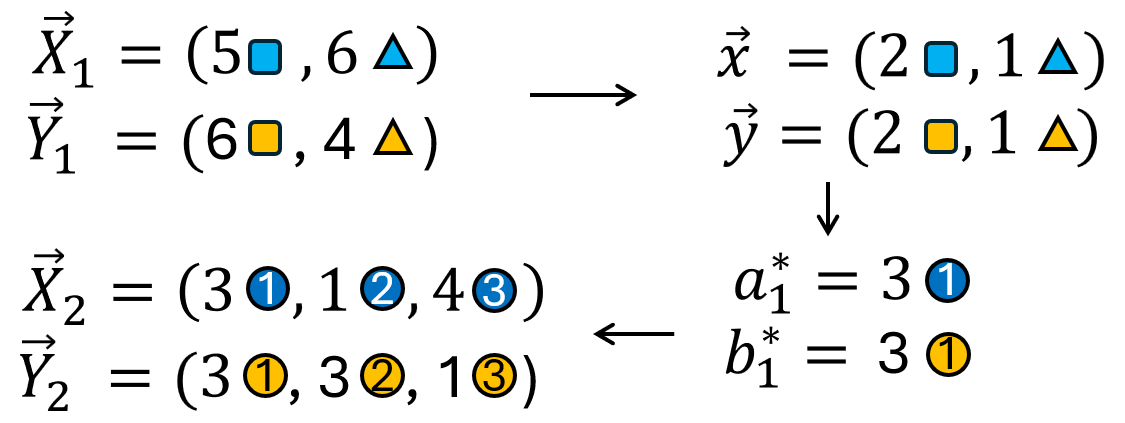
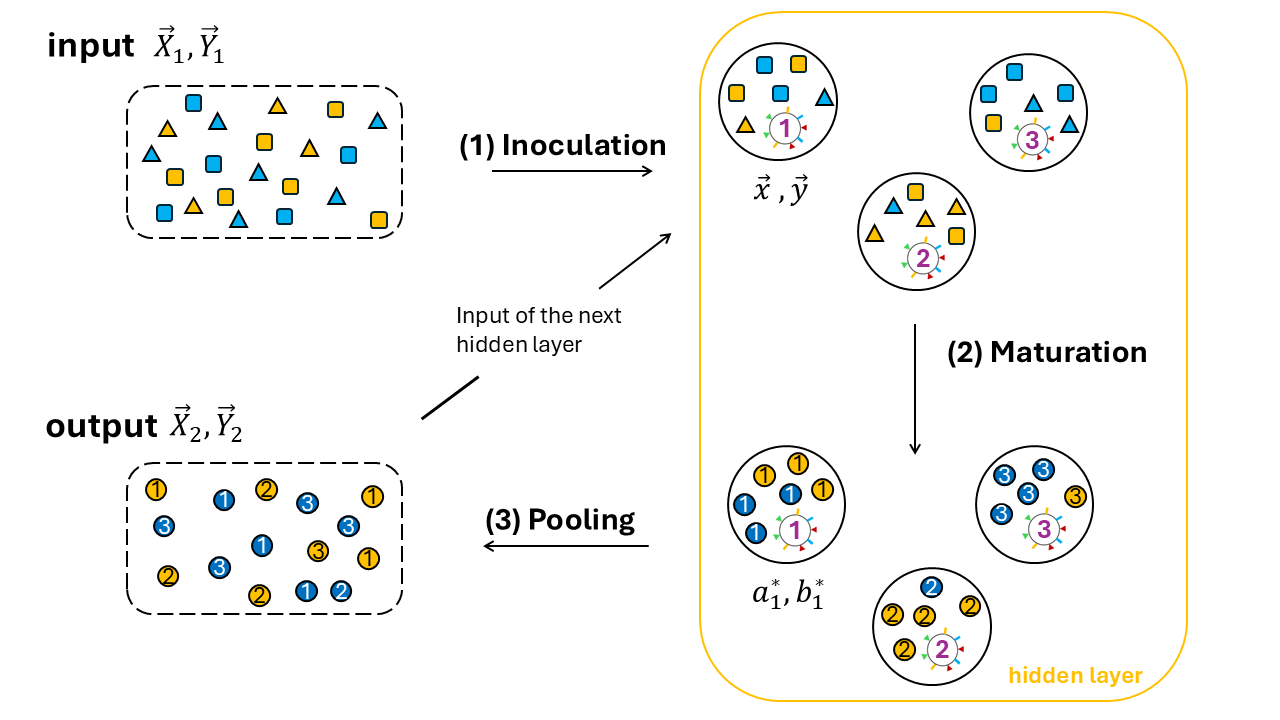

## 2. Simulation

### 2.1 Layer and $\lambda$ dependency of the classification performance

We have the choice to select two pooling methods. The first one ('1') is to sum all output of all neurons without keeping neurons labels, the second one ('2') is to keep the vectorial structure of the output, from the labeling of each neuron.

In [31]:
# Simple Lambda Exploration - Based on Original Fast Code

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import math  # à ajouter en haut si pas déjà fait

# Parametres globaux
lambda_a = 1.0
lambda_b = 1.0
ka = 0.5
kb = 0.5
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2



def neuron_dynamics(t, y, x_in, y_in, w_p_x=1.0, w_p_y=1.0):
    a, b = y
    da_dt = w_p_x * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_p_y * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

# Couche commune a l'approche 1 et 2
def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons, lambda_override=None):
    X_total = np.sum(X_bulk_vec)
    Y_total = np.sum(Y_bulk_vec)
    lambda_total = lambda_override if lambda_override is not None else (X_total + Y_total) / n_neurons

    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_bulk_vec / X_total if X_total > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_total if Y_total > 0 else np.zeros_like(Y_bulk_vec)

    a_vec = []
    b_vec = []
    for _ in range(n_neurons):
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0

        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        sol = solve_ivp(neuron_dynamics, [0, 50], [0.0, 0.0], args=(x_in, y_in), method='LSODA')
        a_vec.append(sol.y[0, -1])
        b_vec.append(sol.y[1, -1])

    return np.array(a_vec), np.array(b_vec)

# Approche 1 : outputs sommees a chaque couche
def simulate_network_sum(X_vec, Y_vec, n_layers, n_neurons, lambda_override=None):
    for _ in range(n_layers):
        a_out, b_out = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override)
        X_vec = np.array([np.sum(a_out)])
        Y_vec = np.array([np.sum(b_out)])
    return np.sum(X_vec), np.sum(Y_vec)

# Approche 2 : outputs gardes en vecteurs
def simulate_network_vector(X, Y, n_layers, n_neurons, lambda_override=None):
    X_vec = np.full(n_neurons, X / n_neurons)
    Y_vec = np.full(n_neurons, Y / n_neurons)

    for _ in range(n_layers):
        X_vec, Y_vec = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override)

    return np.sum(X_vec), np.sum(Y_vec)

def run_simulation(n_layers, n_neurons, n_points, lambda_override=None):
    """Run simulation for a given lambda value"""
    # --- Grille de simulation ---
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    lambda_str = f"λ={lambda_override}" if lambda_override is not None else "λ=auto"
    iterator = tqdm(range(X_grid.size), desc=f"Simulation {lambda_str}")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]

        X_input = X_grid[i, j]
        Y_input = Y_grid[i, j]

        if approach == 1:
            a_final, b_final = simulate_network_sum(np.array([X_input]), np.array([Y_input]), n_layers, n_neurons, lambda_override)
        elif approach == 2:
            a_final, b_final = simulate_network_vector(X_input, Y_input, n_layers, n_neurons, lambda_override)
        else:
            raise ValueError("Approach must be 1 or 2")

        Z_grid[i, j] = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0

    return X_grid, Y_grid, Z_grid


Testing λ values with approach 1
Network: 1 layers, 3 neurons per layer
Grid: 50x50 points

Running with λ = auto


Simulation λ=auto: 100%|██████████| 2500/2500 [00:19<00:00, 130.61it/s]



Running with λ = 1.0


Simulation λ=1.0: 100%|██████████| 2500/2500 [00:05<00:00, 442.45it/s]



Running with λ = 10.0


Simulation λ=10.0: 100%|██████████| 2500/2500 [00:17<00:00, 145.72it/s]



Running with λ = 60.0


Simulation λ=60.0: 100%|██████████| 2500/2500 [00:20<00:00, 120.52it/s]



Running with λ = 1000.0


Simulation λ=1000.0: 100%|██████████| 2500/2500 [00:26<00:00, 95.77it/s] 



Generating comparison plot...


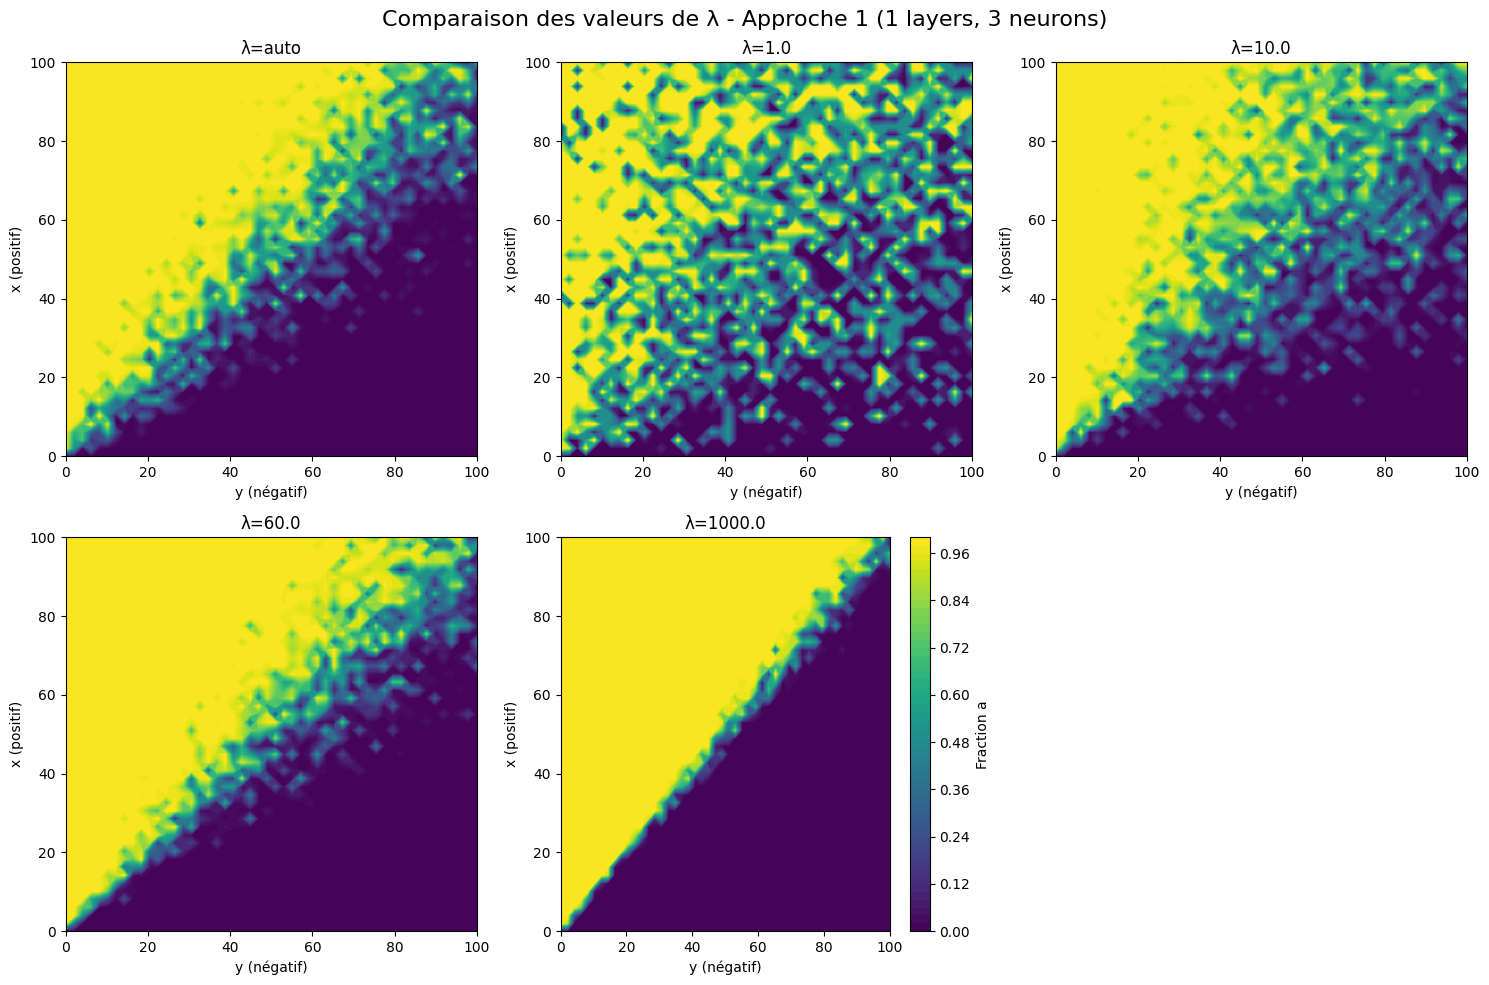


Simulation completed!


In [32]:
# --- Main execution ---
if __name__ == "__main__":

    # Poids fixes pour tous les neurones
    neuron_weights = [(np.random.uniform(0.5, 1.5), np.random.uniform(0.5, 1.5))for _ in range(n_neurons)]

    # Choix de l'approche: 1 = somme (approche 1), 2 = vectorielle (approche 2)
    approach = 1  # Changez ici pour switcher entre 1 ou 2
    # === SIMULATION PARAMETERS ===
    n_layers = 1           # Number of layers in the network
    n_neurons = 3          # Number of neurons per layer
    n_points = 50          # Number of points for x and y grids (50x50 = 2500 points)
    
    # Test different lambda values
    lambda_values = [None, 1.0, 10.0, 60.0,1000.0]
    
    print(f"Testing λ values with approach {approach}")
    print(f"Network: {n_layers} layers, {n_neurons} neurons per layer")
    print(f"Grid: {n_points}x{n_points} points")
    print("=" * 50)
    
    results = {}
    
    for lambda_val in lambda_values:
        print(f"\nRunning with λ = {lambda_val if lambda_val is not None else 'auto'}")
        
        # Run simulation
        X_grid, Y_grid, Z_grid = run_simulation(n_layers, n_neurons, n_points, lambda_val)
        
        # Store results
        results[lambda_val] = (X_grid, Y_grid, Z_grid)
    
    # Plot comparison
    print("\nGenerating comparison plot...")

    n_plots = len(lambda_values)
    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.atleast_1d(axes).flatten()  # toujours obtenir un tableau plat, même pour 1 subplot

    for i, lambda_val in enumerate(lambda_values):
        X_grid, Y_grid, Z_grid = results[lambda_val]

        im = axes[i].contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)

        lambda_str = f"λ={lambda_val}" if lambda_val is not None else "λ=auto"
        axes[i].set_title(lambda_str)
        axes[i].set_xlabel('y (négatif)')
        axes[i].set_ylabel('x (positif)')

    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i])
    cbar.set_label('Fraction a', fontsize=10)

    # Supprime les axes inutilisés si le nombre de subplots dépasse le nombre de lambda_values
    for j in range(len(lambda_values), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Comparaison des valeurs de λ - Approche {approach} ({n_layers} layers, {n_neurons} neurons)', fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nSimulation completed!")

We simulated a neural network of 1 layer with 3 neurons. We ploted the decision boundary for differents values of $\lambda$ which is the average number of inputs in each neuron. $\lambda_{auto}$ is the total number of inputs in the bulk divided by the number of neuron. We observe that the higher $\lambda$ is, the more and more defined the boundary is. Indeed, the spread of the boundary is a result of the bulk sampling. Thus, the more input there are, the lower the effect of sampling is. This is what we oberse below, where we ploted the anti diagonal output profile of previous graph.


Lancement des simulations le long de la diagonale...


Diag λ=1000.0: 100%|██████████| 120/120 [00:01<00:00, 98.17it/s] 


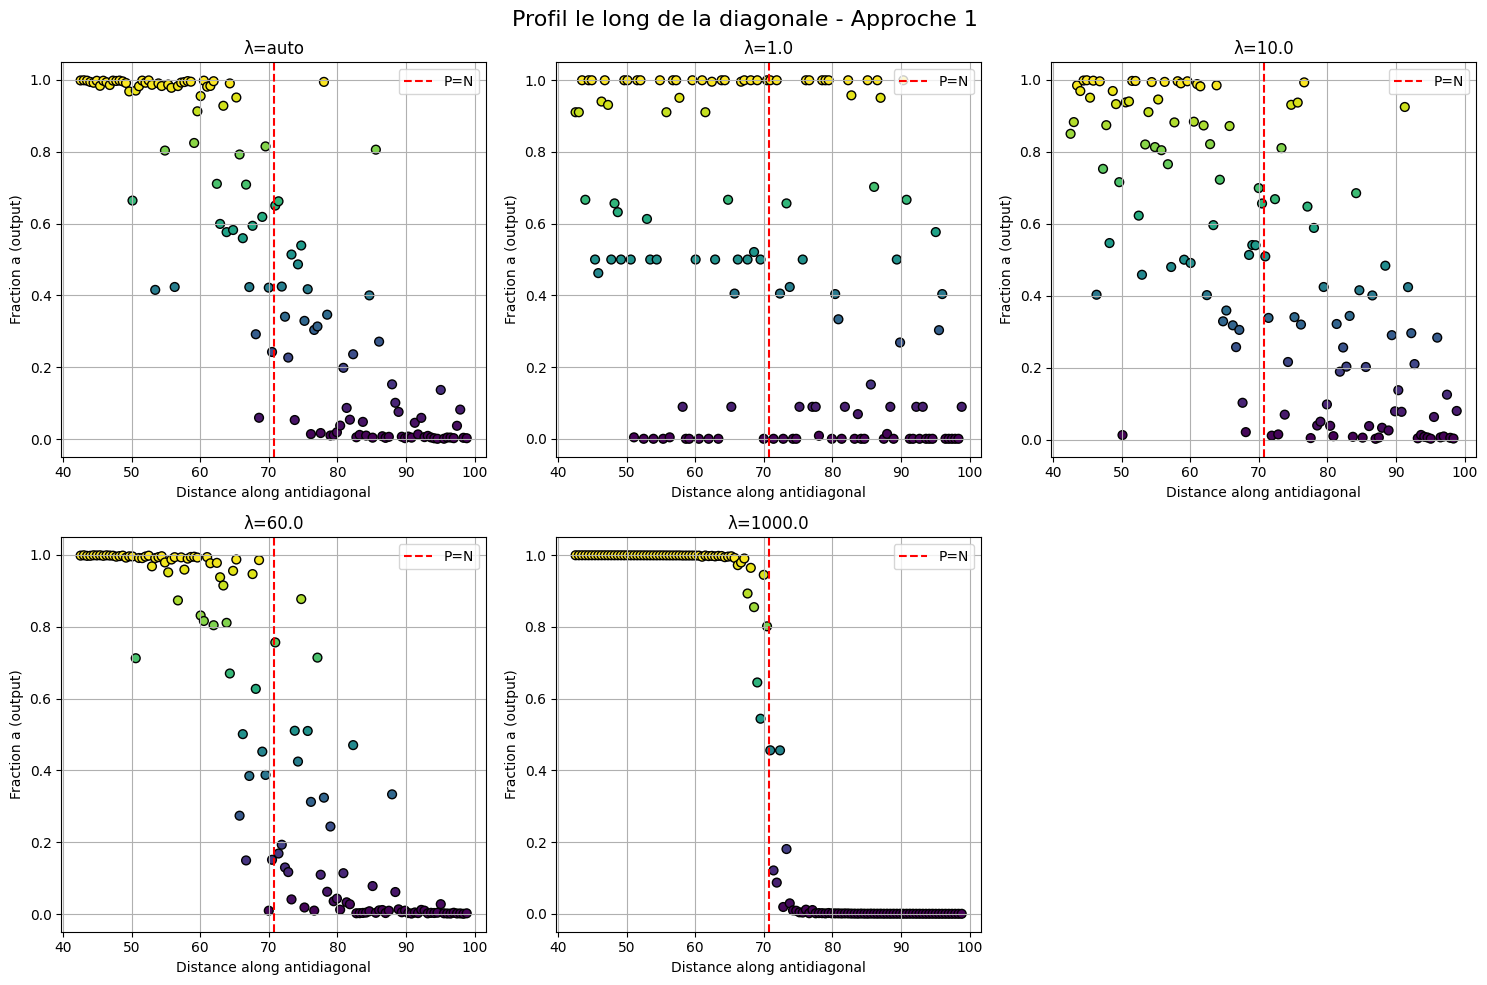

In [18]:
# --- PARTIE DIAGONALE POUR TOUTES LES VALEURS DE LAMBDA ---

print("\nLancement des simulations le long de la diagonale...")

# Préparation des paramètres diagonaux
max_val = 100
center = max_val / 2
width_fraction = 0.4

diag_length = np.sqrt(2) * max_val
half_window = diag_length * width_fraction / 2

n_diag_points = 300
P_full = np.linspace(max_val, 0, n_diag_points)
N_full = np.linspace(0, max_val, n_diag_points)

dist_full = np.sqrt((P_full - P_full[0])**2 + (N_full - N_full[0])**2)
center_dist = diag_length / 2
mask = (dist_full >= center_dist - half_window) & (dist_full <= center_dist + half_window)

P_diag = P_full[mask]
N_diag = N_full[mask]
dist_diag = dist_full[mask]

# Subplots pour les courbes diagonales
fig_diag, axes_diag = plt.subplots(2, 3, figsize=(15, 10))
axes_diag = axes_diag.flatten()

for i, lambda_val in enumerate(lambda_values):
    Z_diag = []
    desc = f"Diag λ={lambda_val if lambda_val is not None else 'auto'}"
    for P_input, N_input in tqdm(zip(P_diag, N_diag), total=len(P_diag), desc=desc):
        if approach == 1:
            a_final, b_final = simulate_network_sum(np.array([P_input]), np.array([N_input]), n_layers, n_neurons, lambda_override=lambda_val)
        elif approach == 2:
            a_final, b_final = simulate_network_vector(P_input, N_input, n_layers, n_neurons, lambda_override=lambda_val)
        else:
            raise ValueError("Approach must be 1 or 2")

        ratio = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0
        Z_diag.append(ratio)

    Z_diag = np.array(Z_diag)
    
    ax = axes_diag[i]
    sc = ax.scatter(dist_diag, Z_diag, c=Z_diag, cmap='viridis', s=40, edgecolor='black')
    ax.axvline(x=center_dist, color='red', linestyle='--', linewidth=1.5, label='P=N')
    lambda_str = f"λ={lambda_val}" if lambda_val is not None else "λ=auto"
    ax.set_title(lambda_str, fontsize=12)
    ax.set_xlabel('Distance along antidiagonal')
    ax.set_ylabel('Fraction a (output)')
    ax.legend(fontsize=10)
    ax.grid(True)

# Supprimer les axes inutiles si <6 lambdas
for j in range(len(lambda_values), len(axes_diag)):
    fig_diag.delaxes(axes_diag[j])

plt.suptitle(f'Profil le long de la diagonale - Approche {approach}', fontsize=16)
plt.tight_layout()
plt.show()



Testing different layer counts with λ = 500.0 and approach 1
Network: 3 neurons per layer
Grid: 50x50 points

Running with n_layers = 1


Simulation λ=500.0: 100%|██████████| 2500/2500 [00:24<00:00, 101.47it/s]



Running with n_layers = 2


Simulation λ=500.0: 100%|██████████| 2500/2500 [00:42<00:00, 59.17it/s]



Running with n_layers = 3


Simulation λ=500.0: 100%|██████████| 2500/2500 [00:46<00:00, 53.59it/s]



Running with n_layers = 5


Simulation λ=500.0: 100%|██████████| 2500/2500 [01:01<00:00, 40.95it/s]



Generating comparison plot...


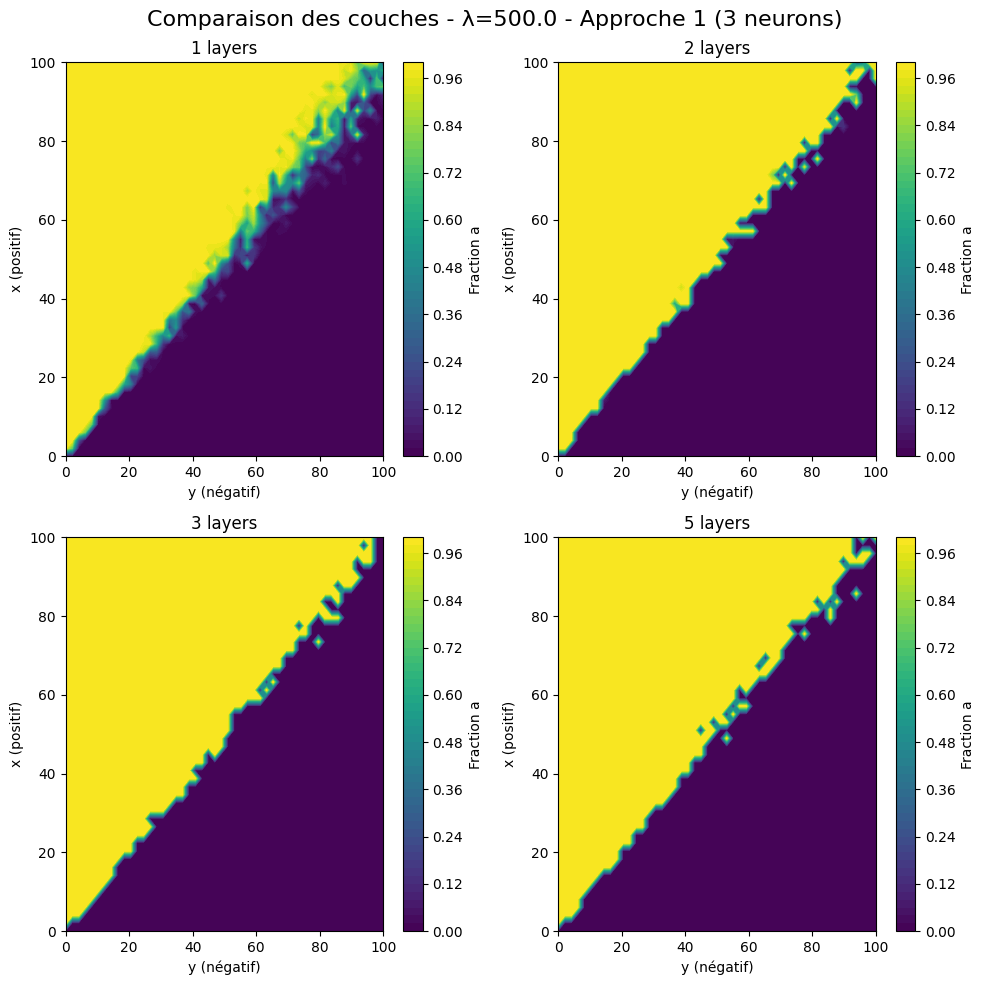


Simulation completed!


In [20]:
# --- Main execution ---
if __name__ == "__main__":
    import math  # à ajouter si pas déjà importé

    # Choix de l'approche: 1 = somme (approche 1), 2 = vectorielle (approche 2)
    approach = 1  # Changez ici pour switcher entre 1 ou 2

    # === SIMULATION PARAMETERS ===
    n_neurons = 3          # Nombre de neurones par couche
    n_points = 50          # Nombre de points pour x et y (50x50)
    lambda_val = 500.0      # Fixe une seule valeur de lambda pour cette analyse

    layer_values = [1, 2, 3, 5]  # Valeurs de n_layers à tester

    print(f"Testing different layer counts with λ = {lambda_val} and approach {approach}")
    print(f"Network: {n_neurons} neurons per layer")
    print(f"Grid: {n_points}x{n_points} points")
    print("=" * 50)

    results = {}

    for n_layers in layer_values:
        print(f"\nRunning with n_layers = {n_layers}")
        
        # Run simulation
        X_grid, Y_grid, Z_grid = run_simulation(n_layers, n_neurons, n_points, lambda_val)
        
        # Store results
        results[n_layers] = (X_grid, Y_grid, Z_grid)

    # Plot comparison
    print("\nGenerating comparison plot...")

    n_plots = len(layer_values)
    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.atleast_1d(axes).flatten()  # Pour gérer le cas n_layers = 1

    for i, n_layers in enumerate(layer_values):
        X_grid, Y_grid, Z_grid = results[n_layers]

        im = axes[i].contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)

        axes[i].set_title(f"{n_layers} layers")
        axes[i].set_xlabel('y (négatif)')
        axes[i].set_ylabel('x (positif)')

        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i])
        cbar.set_label('Fraction a', fontsize=10)

    # Supprimer les axes inutilisés
    for j in range(len(layer_values), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Comparaison des couches - λ={lambda_val} - Approche {approach} ({n_neurons} neurons)', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\nSimulation completed!")


We indeed have that the more we add layers, the more defined will be the decision boundary. 

### 2.2 Weights tunning

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import math



def neuron_dynamics(t, y, x_in, y_in, w_p_x=1.0, w_p_y=1.0):
    a, b = y
    da_dt = w_p_x * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_p_y * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]


def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons, lambda_override=None, neuron_weights=None):
    X_total = np.sum(X_bulk_vec)
    Y_total = np.sum(Y_bulk_vec)
    lambda_total = lambda_override if lambda_override is not None else (X_total + Y_total) / n_neurons

    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_bulk_vec / X_total if X_total > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_total if Y_total > 0 else np.zeros_like(Y_bulk_vec)

    a_vec = []
    b_vec = []
    for i in range(n_neurons):
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0

        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        w_p_x, w_p_y = neuron_weights[i] if neuron_weights is not None else (1.0, 1.0)

        sol = solve_ivp(
            neuron_dynamics, [0, 50], [0.0, 0.0],
            args=(x_in, y_in, w_p_x, w_p_y),
            method='LSODA'
        )

        a_vec.append(sol.y[0, -1])
        b_vec.append(sol.y[1, -1])

    return np.array(a_vec), np.array(b_vec)


def simulate_network_sum(X_vec, Y_vec, n_layers, n_neurons, lambda_override=None, neuron_weights=None):
    for _ in range(n_layers):
        a_out, b_out = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override, neuron_weights=neuron_weights)
        X_vec = np.array([np.sum(a_out)])
        Y_vec = np.array([np.sum(b_out)])
    return np.sum(X_vec), np.sum(Y_vec)


def simulate_network_vector(X, Y, n_layers, n_neurons, lambda_override=None, neuron_weights=None):
    X_vec = np.full(n_neurons, X / n_neurons)
    Y_vec = np.full(n_neurons, Y / n_neurons)

    for _ in range(n_layers):
        X_vec, Y_vec = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override, neuron_weights=neuron_weights)

    return np.sum(X_vec), np.sum(Y_vec)


def run_simulation(n_layers, n_neurons, n_points, lambda_override=None, neuron_weights=None):
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    iterator = tqdm(range(X_grid.size), desc="Simulation")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]

        X_input = X_grid[i, j]
        Y_input = Y_grid[i, j]

        if approach == 1:
            a_final, b_final = simulate_network_sum(
                np.array([X_input]), np.array([Y_input]),
                n_layers, n_neurons,
                lambda_override=lambda_override,
                neuron_weights=neuron_weights
            )
        elif approach == 2:
            a_final, b_final = simulate_network_vector(
                X_input, Y_input,
                n_layers, n_neurons,
                lambda_override=lambda_override,
                neuron_weights=neuron_weights
            )
        else:
            raise ValueError("Approach must be 1 or 2")

        Z_grid[i, j] = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0

    return X_grid, Y_grid, Z_grid




Comparaison de différentes configurations de poids...


Simulation: 100%|██████████| 2500/2500 [00:40<00:00, 62.26it/s]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13200\4210293069.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


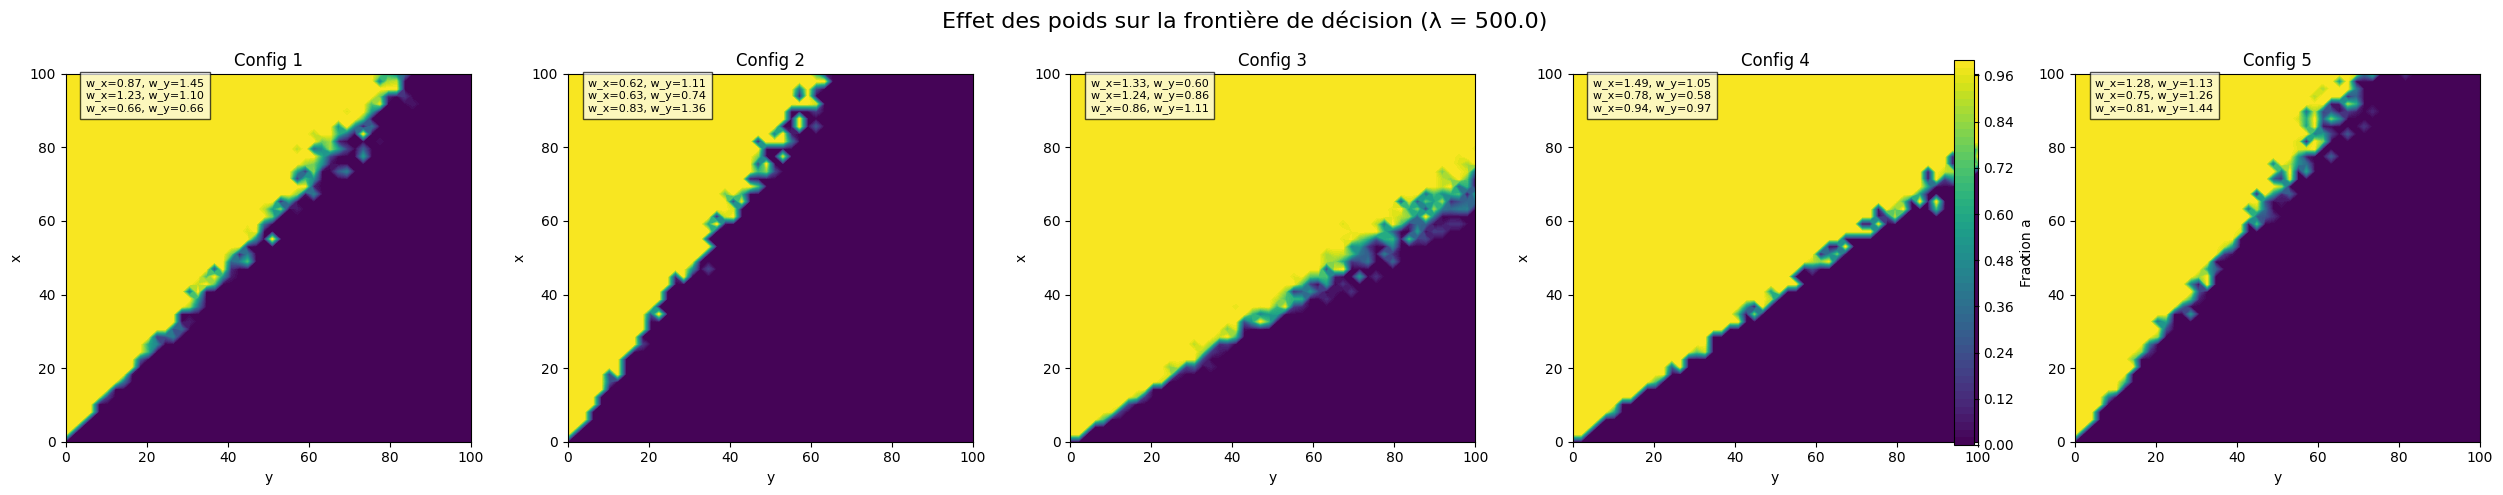

In [17]:
# --- MAIN ---
if __name__ == "__main__":
    # Paramètres globaux
    lambda_a = 1.0
    lambda_b = 1.0
    ka = 0.5
    kb = 0.5
    eta_a = 0.1
    eta_b = 0.1
    mu_ab = 0.2

    approach = 1
    n_layers = 2
    n_neurons = 3
    n_points = 50
    lambda_val = 500.0

    n_trials = 5
    all_results = []

    print("Comparaison de différentes configurations de poids...")

    for trial in range(n_trials):
        np.random.seed(42 + trial)
        neuron_weights = [
            (np.random.uniform(0.5, 1.5), np.random.uniform(0.5, 1.5))
            for _ in range(n_neurons)
        ]
        X_grid, Y_grid, Z_grid = run_simulation(
            n_layers, n_neurons, n_points,
            lambda_override=lambda_val,
            neuron_weights=neuron_weights
        )
        all_results.append((neuron_weights, Z_grid))

    # --- AFFICHAGE ---
    fig, axes = plt.subplots(1, n_trials, figsize=(5 * n_trials, 5))
    axes = np.atleast_1d(axes).flatten()

    for i, (weights, Z) in enumerate(all_results):
        im = axes[i].contourf(Y_grid, X_grid, Z, levels=50, cmap='viridis', vmin=0, vmax=1)
        label = "\n".join([f"w_x={w[0]:.2f}, w_y={w[1]:.2f}" for w in weights])
        axes[i].set_title(f"Config {i+1}")
        axes[i].set_xlabel("y")
        axes[i].set_ylabel("x")
        axes[i].text(5, 90, label, fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    cbar = plt.colorbar(im, ax=axes.tolist())
    cbar.set_label('Fraction a')

    plt.suptitle(f"Effet des poids sur la frontière de décision (λ = {lambda_val})", fontsize=16)
    plt.tight_layout()
    plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from tqdm import tqdm
import math

  # Paramètres globaux
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2


def neuron_dynamics(t, y, x_in, y_in, w_p_x=1.0, w_p_y=1.0):
    a, b = y
    da_dt = w_p_x * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = w_p_y * y_in + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons, lambda_override=None, neuron_weights=None):
    X_total = np.sum(X_bulk_vec)
    Y_total = np.sum(Y_bulk_vec)
    lambda_total = lambda_override if lambda_override is not None else (X_total + Y_total) / n_neurons

    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_bulk_vec / X_total if X_total > 0 else np.zeros_like(X_bulk_vec)
    q_vec = Y_bulk_vec / Y_total if Y_total > 0 else np.zeros_like(Y_bulk_vec)

    a_vec = []
    b_vec = []
    for i in range(n_neurons):
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0

        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        w_p_x, w_p_y = neuron_weights[i] if neuron_weights is not None else (1.0, 1.0)

        sol = solve_ivp(
            neuron_dynamics, [0, 50], [0.0, 0.0],
            args=(x_in, y_in, w_p_x, w_p_y),
            method='LSODA'
        )

        a_vec.append(sol.y[0, -1])
        b_vec.append(sol.y[1, -1])

    return np.array(a_vec), np.array(b_vec)

def simulate_network_sum(X_vec, Y_vec, n_layers, n_neurons, lambda_override=None, neuron_weights=None):
    for _ in range(n_layers):
        a_out, b_out = simulate_layer(X_vec, Y_vec, n_neurons, lambda_override=lambda_override, neuron_weights=neuron_weights)
        X_vec = np.array([np.sum(a_out)])
        Y_vec = np.array([np.sum(b_out)])
    return np.sum(X_vec), np.sum(Y_vec)

def run_simulation(n_layers, n_neurons, n_points, lambda_override=None, neuron_weights=None):
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    total_points = X_grid.size
    iterator = tqdm(range(total_points), desc="Simulation")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]
        X_input = X_grid[i, j]
        Y_input = Y_grid[i, j]
        a_final, b_final = simulate_network_sum(np.array([X_input]), np.array([Y_input]),
                                               n_layers, n_neurons,
                                               neuron_weights=neuron_weights,
                                               lambda_override=lambda_override)
        Z_grid[i, j] = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0
    return X_grid, Y_grid, Z_grid




Simulation: 100%|██████████| 2500/2500 [00:26<00:00, 95.10it/s]


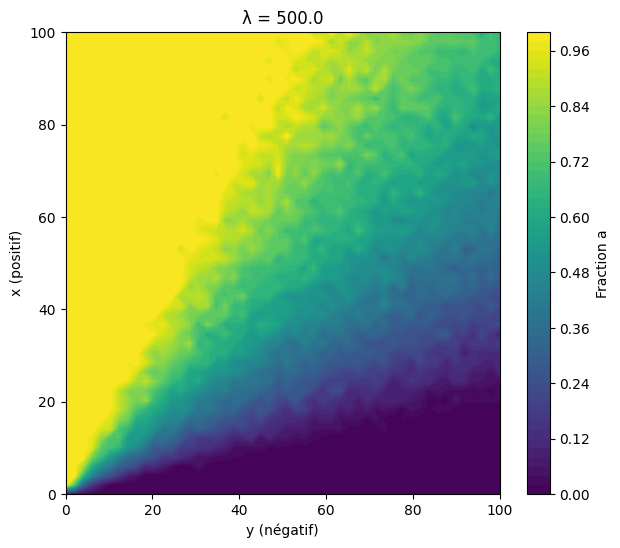

In [19]:
if __name__ == "__main__":

      # Paramètres globaux
    lambda_a = 1.0
    lambda_b = 1.0
    ka = 0.3
    kb = 0.8
    eta_a = 0.1
    eta_b = 0.1
    mu_ab = 0.2

    
    approach = 1
    n_layers = 1
    n_neurons = 3
    n_points = 50
    lambda_val = 500.0

    # Poids initiaux
    initial_weights = [
        [1.0, 0.2],
        [0.8,0.2],
        [0.8, 1.5],
    ]
    assert len(initial_weights) == n_neurons

    # Grille fixe pour affichage
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)

    # Calcul de la simulation avec la barre de progression tqdm
    weights = [(w[0], w[1]) for w in initial_weights]
    X_grid, Y_grid, Z_grid = run_simulation(
        n_layers, n_neurons, n_points,
        lambda_override=lambda_val,
        neuron_weights=weights
    )

    # Affichage statique
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(im, ax=ax, label="Fraction a")
    ax.set_xlabel("y (négatif)")
    ax.set_ylabel("x (positif)")
    ax.set_title(f"λ = {lambda_val}")

    plt.show()



In [20]:
def neuron_dynamics(t, y, x_vec, y_vec, w_p_x_vec, w_p_y_vec): #prend en input les vecteurs d'inputs et vecteurs de poids
    a, b = y
    da_dt = np.dot(w_p_x_vec, x_vec) + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = np.dot(w_p_y_vec, y_vec) + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def simulate_layer(X_bulk_vec, Y_bulk_vec, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override=None):
    X_total = np.sum(X_bulk_vec)
    Y_total = np.sum(Y_bulk_vec)
    lambda_total = lambda_override if lambda_override is not None else (X_total + Y_total) / n_neurons

    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_bulk_vec / X_total if X_total > 0 else np.zeros_like(X_bulk_vec) #vecteur de proba pour la distribution parmis les especes positives
    q_vec = Y_bulk_vec / Y_total if Y_total > 0 else np.zeros_like(Y_bulk_vec) #vecteur de proba pour la distribution parmis les especes negatives

    a_vec = []
    b_vec = []
    for _ in range(n_neurons):
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0

        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_bulk_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_bulk_vec)

        sol = solve_ivp(neuron_dynamics, [0, 50], [0.0, 0.0], args=(x_vec, y_vec, w_p_x_vec, w_p_y_vec), method='LSODA')
        a_vec.append(sol.y[0, -1])
        b_vec.append(sol.y[1, -1])

    return np.array(a_vec), np.array(b_vec)

def simulate_network_sum(X_vec, Y_vec, n_layers, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override=None):
    for _ in range(n_layers):
        a_out, b_out = simulate_layer(X_vec, Y_vec, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override=lambda_override)
        X_vec = np.array([np.sum(a_out)])
        Y_vec = np.array([np.sum(b_out)])
        # Adapter poids : on réduit à un poids unique moyen (optionnel, selon modèle)
        w_p_x_vec = np.array([np.sum(w_p_x_vec)])
        w_p_y_vec = np.array([np.sum(w_p_y_vec)])
    return np.sum(X_vec), np.sum(Y_vec)

def simulate_network_vector(X, Y, n_layers, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override=None):
    X_vec = np.full(n_neurons, X / n_neurons)
    Y_vec = np.full(n_neurons, Y / n_neurons)

    # Répéter les poids pour avoir le même nombre de neurones
    w_p_x_vec_rep = np.tile(w_p_x_vec / len(w_p_x_vec), n_neurons)
    w_p_y_vec_rep = np.tile(w_p_y_vec / len(w_p_y_vec), n_neurons)

    for _ in range(n_layers):
        X_vec, Y_vec = simulate_layer(X_vec, Y_vec, n_neurons, w_p_x_vec_rep, w_p_y_vec_rep, lambda_override=lambda_override)

    return np.sum(X_vec), np.sum(Y_vec)

def run_simulation(n_layers, n_neurons, n_points, w_p_x_vec, w_p_y_vec, lambda_override=None):
    """Run simulation for a given lambda value"""
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    lambda_str = f"λ={lambda_override}" if lambda_override is not None else "λ=auto"
    iterator = tqdm(range(X_grid.size), desc=f"Simulation {lambda_str}")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]

        X_input = X_grid[i, j]
        Y_input = Y_grid[i, j]

        if approach == 1:
            a_final, b_final = simulate_network_sum(
                np.array([X_input]), np.array([Y_input]), n_layers, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override)
        elif approach == 2:
            a_final, b_final = simulate_network_vector(
                X_input, Y_input, n_layers, n_neurons, w_p_x_vec, w_p_y_vec, lambda_override)
        else:
            raise ValueError("Approach must be 1 or 2")

        Z_grid[i, j] = a_final / (a_final + b_final) if (a_final + b_final) > 0 else 0.0

    return X_grid, Y_grid, Z_grid



## 3.Analytical work

regarder la dépendance en lambda (papier gabin) lambda environ 1 regime particulier. regarder ce qu'il se passe quand lambda est de 1. \deltax = \delta a pour moi entre le debut et la fin du premier round. fraction de a après un round en fonction de lambda det on drevait voir 2 zones . comparer avec diagramme bulk si lambda>>>1 et tj meme chose alors cpt joue pas

VOIR AVEC DES POIDS DIFFERENTS POUR LES ENTREES ET CE QUE CA CHANGE POUR LA DENSITE DE PROBA
